# Data Preparation
### Training a Neural Network to identify the best M3 Combo
By Zach Shelton
5/13/21


In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan

In [27]:
from __future__ import print_function, division
import uproot
import numpy as np
#Make sure to install both old awkward0 and new awkward1(referred to now as awkward)
import awkward1 as ak
import awkward0 as ak0
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import coffea.hist as hist
import matplotlib.pyplot as plt
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

In [28]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema,entry_stop=500).events()

In [29]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4)
tightJet = jets[jetSel]
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final = events[eventSel]

In [30]:
#G = Global index of particles - Artifact from Coffea/NanoAOD Tools
print(len(final))

308


In [31]:
genPart = final.GenPart
tops = genPart[abs(genPart.pdgId)==6]
tops = tops[tops.hasFlags('isLastCopy')]
print(tops.pdgId)
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
print(tDecay.pdgId)
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
print(WDecay.pdgId)
#t_events is the lone bottom, W_events is the -> two jets

[[6, -6], [6, -6], [6, -6], [6, -6], [6, ... -6], [6, -6], [6, -6], [6, -6], [6, -6]]
[[[24, 5], [-24, -5]], [[24, 5], [-24, -5, ... 5], [-24, -5]], [[24, 5], [-24, -5]]]
[[[[2, -1]], [[15, -16]]], [[[4, -3]], ... [[15, -16]]], [[[2, -1]], [[13, -14]]]]


In [32]:
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)


In [33]:
qqb_events=ak.concatenate([t_Events,W_Events],axis=2)
print(qqb_events[0].pdgId)
qqbmask=((ak.count(qqb_events.pt,axis=2)>2))
print(qqbmask)
hadronicevents=qqb_events[qqbmask]

[[5, 2, -1], [-5]]
[[True, False], [True, False], [False, True, ... True], [True, False], [True, False]]


In [34]:
from coffea.nanoevents.methods import vector
import uproot_methods
ak.behavior.update(vector.behavior)
#jet_kinematics=uproot_methods.TLorentzVectorArray.from_ptetaphim(final.Jet.pt,final.Jet.eta,final.Jet.phi,final.Jet.mass)

In [159]:
    def nearest(
        self,
        other,
        axis=1,
        metric=lambda a, b: a.delta_r(b),
        return_metric=False,
        threshold=None,
    ):
        """Return nearest object to this one
        Finds item in ``other`` satisfying ``min(metric(self, other))``.
        The two arrays should be broadcast-compatible on all axes other than the specified
        axis, which will be used to form a cartesian product. If axis=None, broadcast arrays directly.
        The return shape will be that of ``self``.
        Parameters
        ----------
            other : awkward.Array
                Another array with same shape in all but ``axis``
            axis : int, optional
                The axis to form the cartesian product (default 1). If None, the metric
                is directly evaluated on the input arrays (i.e. they should broadcast)
            metric : callable
                A function of two arguments, returning a scalar. The default metric is `delta_r`.
            return_metric : bool, optional
                If true, return both the closest object and its metric (default false)
            threshold : Number, optional
                If set, any objects with ``metric > threshold`` will be masked from the result
        """
        mval, (a, b) = self.metric_table(other, axis, metric, return_combinations=True)
        if axis is None:
            # NotImplementedError: awkward.firsts with axis=-1
            axis = other.layout.purelist_depth - 2
        mmin = awkward.argmin(mval, axis=axis + 1, keepdims=True)
        out = awkward.firsts(b[mmin], axis=axis + 1)
        metric = awkward.firsts(mval[mmin], axis=axis + 1)
        if threshold is not None:
            out = out.mask[metric <= threshold]
        if return_metric:
            return out, metric
        return out

In [ ]:
print(hadronic)

In [168]:
jet_kinematics=ak.zip({"pt":final.Jet.pt,"eta":final.Jet.eta,"phi":final.Jet.phi,"mass":final.Jet.mass},with_name="PtEtaPhiMLorentzVector")
j_data=ak.zip({"p4":jet_kinematics,"btag":final.Jet.btagDeepFlavB,"area":final.Jet.area,"event":final.event})

hadronicevents[1][0][0].nearest(j_data.p4[1])

TypeError: GenParticle cannot be converted into an Awkward Array

(https://github.com/scikit-hep/awkward-1.0/blob/0.4.5/src/awkward1/operations/convert.py#L1578)

In [61]:
#This uses Delta_r as the GenPart/Jet does not inherit nearest(), which is annoying. So the first loop run delta_r for each jet to every GenPart.
jet_kinematics=ak.zip({"pt":final.Jet.pt,"eta":final.Jet.eta,"phi":final.Jet.phi,"mass":final.Jet.mass},with_name="PtEtaPhiMLorentzVector")
j_data=ak.zip({"p4":jet_kinematics,"btag":final.Jet.btagDeepFlavB,"area":final.Jet.area,"event":final.event})

In [155]:
t_delta=ak.ArrayBuilder()
for x in range(0,len(j_data)):
    #print(j_data)
    l=ak.ArrayBuilder()
    if(len(hadronicevents[x])>0):
        for h in hadronicevents[x]:
            #print(ak.argmin(h[0].delta_r(j_data.p4[x])))
            #print(h[0].delta_r(j_data.p4[x]))
            #print(h[0].pdgId)
            #print(ak.argmin(h[1].delta_r(j_data.p4[x])))
            #print(h[1].delta_r(j_data.p4[x]))
            #print(h[1].pdgId)
            #print(ak.argmin(h[2].delta_r(j_data.p4[x])))
            #print(h[2].delta_r(j_data.p4[x]))
            #print(h[2].pdgId)
            l.append((ak.argmin(h[0].delta_r(j_data.p4[x])),ak.argmin(h[1].delta_r(j_data.p4[x])),ak.argmin(h[2].delta_r(j_data.p4[x]))))
    else:
        l.append((None,None,None))
    t_delta.append((l['0'],l['1'],l['2']))
print(len(t_delta))
print()
args=ak.argcombinations(j_data,3,highlevel=True)
combs=ak.combinations(j_data,3,highlevel=True) 
t=((args['0']==ak.flatten(t_delta['0']))&(args['1']==ak.flatten(t_delta['1']))&(args['2']==ak.flatten(t_delta['2'])))
validation=ak.flatten(t)
recofinal=combs['0']+combs['1']+combs['2']
test_reco=ak.flatten(recofinal)
test_jets=ak.flatten(combs,axis=-1)
#Test_reco = Recombined Data
#Test_jets = Combination values
#Validation = Validation data(True/False)

308



In [ ]:
from matplotlib import pyplot as plt

### Observations
1. There is a clear separation of mass, indicating that the process above is correctly selecting values (with outliers)

392.66238 372.9613


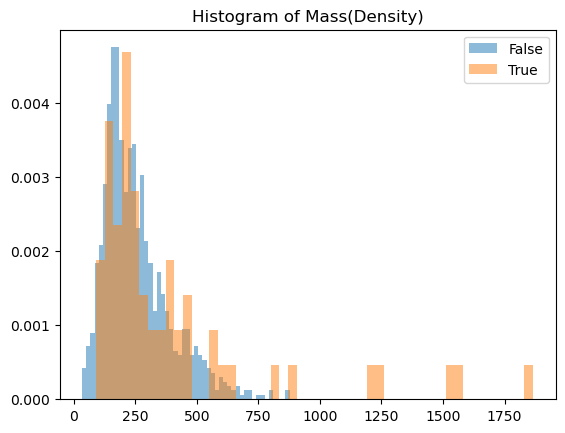

In [158]:
good=test_reco[validation]
bad=test_reco[np.invert(validation)]
from scipy.stats import norm
good_fitmu,gfstd=norm.fit(np.array(good.p4.mass))
bad_fitmu,bfstd=norm.fit(bad.p4.mass)
xmin, xmax = 0,2000
x = np.linspace(xmin, xmax, 800)
#p1 = norm.pdf(x, good_fitmu, gfstd)
#plt.plot(x, p1, 'k', linewidth=2)
#p2 = norm.pdf(x, bad_fitmu, bfstd)
#plt.plot(x, p2, 'k', linewidth=2)
print(good_fitmu,gfstd)
plt.hist(bad['p4'].mass[0:1000],bins=50,alpha=.5,density=True)
plt.hist(good['p4'].mass,bins=50,alpha=.5,density=True)
plt.legend(["False","True"])
plt.title("Histogram of Mass(Density)")
plt.show()
plt.savefig("tfmass.png")

In [ ]:
outliers=good[good['p4'].mass>250]
print(len(outliers.p4.pt))


### Observations:
1. Not many differences in the Kinematics of true and false data(at visual observation)

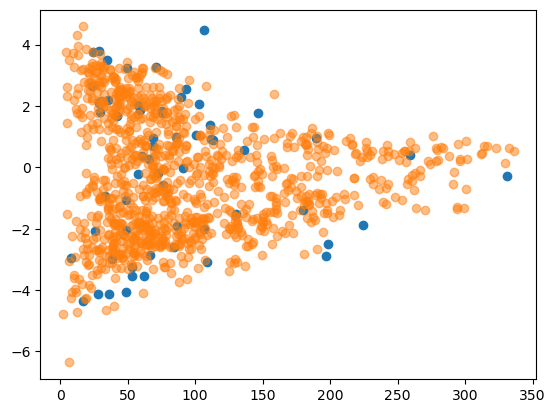

In [147]:
plt.scatter(good['p4'].pt,good['p4'].eta)
plt.scatter(bad['p4'].pt[0:1000],bad['p4'][0:1000].eta,alpha=.5)
plt.show()

In [148]:
t_array=ak.ArrayBuilder()
for val in test_jets:
    t_array.append([val['0']['p4'].delta_r(val['1']['p4']),
                    val['0']['p4'].delta_r(val['2']['p4']),
                    val['1']['p4'].delta_r(val['2']['p4'])])
print(len(validation))
good_deltar=t_array[validation]
bad_deltar=t_array[np.invert(validation)]

23402


In [ ]:
#ISSUE, some of the jets

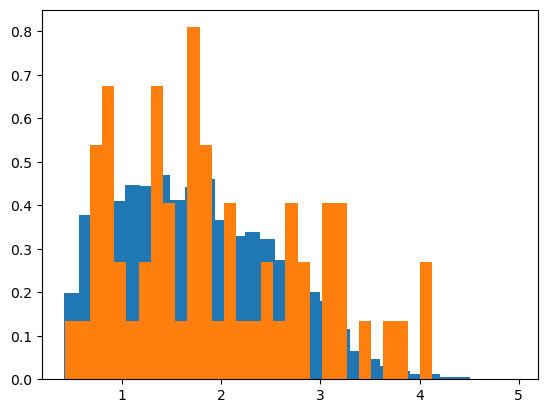

In [150]:
plt.hist(ak.min(bad_deltar,axis=1),bins=30,density=True)
plt.hist(ak.min(good_deltar,axis=1),bins=30,density=True)
plt.show()

______________________________________________________________________________
# Running Notes and questions
- Losing Data because of arbitrary 8 jet cut?

## Notes for Zach to keep up

Wrap into Coffea Executor!!!!!!!!!!!!

Seperate values, weights and triggers(X)
read these into tensors for Keras(X)
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch

## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable